In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import re
import jieba
import gensim
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/Users/yangchaoran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yangchaoran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv(r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/tap_reviews cleaned.csv", encoding='utf_8_sig')

/var/folders/9p/6kysksz51c5dp1tvm7_wk8xm0000gn/T/ipykernel_38347/2558096381.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(len_se, bins=20, hist=True, kde=True, rug=True)


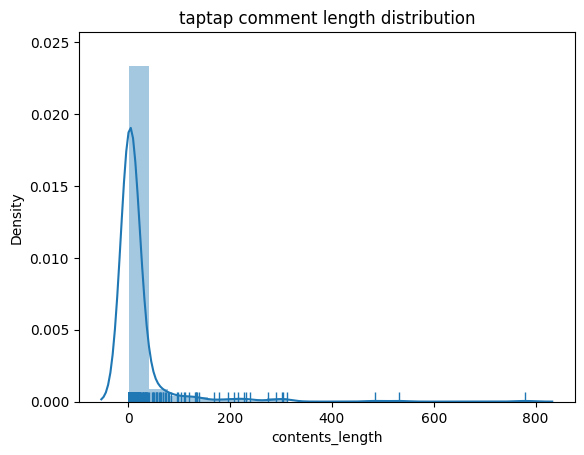

评论长度的9/10分位数： 123.0


In [4]:
# 查看评论长度分布
data['contents_length'] = data['contents'].apply(lambda x: len(str(x)))
len_se = data.groupby('contents_length')['contents_length'].count()
sns.distplot(len_se, bins=20, hist=True, kde=True, rug=True)
plt.title('taptap comment length distribution')
plt.show()
print('评论长度的9/10分位数：', data['contents_length'].quantile(0.9))

/var/folders/9p/6kysksz51c5dp1tvm7_wk8xm0000gn/T/ipykernel_38347/4238701920.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)


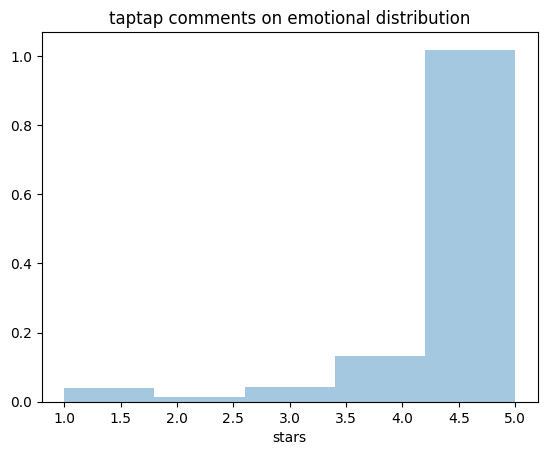

正面评价: 9101，占总数的92.12%    负面评价: 779, 占总数的7.88%


In [5]:
positive = len(data['stars'][data['stars'] >= 4])
total = len(data['stars'])
negative = total - positive
sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)
plt.title('taptap comments on emotional distribution')
plt.show()
print('正面评价: %d，占总数的%.2f%%    负面评价: %d, 占总数的%.2f%%' %
      (positive, (positive/total*100), negative, (negative/total*100)))

扩充评论条数 17919


/var/folders/9p/6kysksz51c5dp1tvm7_wk8xm0000gn/T/ipykernel_38347/91930805.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)


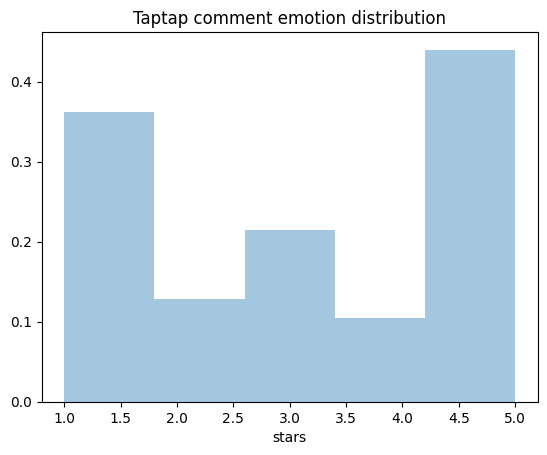

正面评价: 12105，占总数的43.54%    负面评价: 15694, 占总数的56.46%


In [7]:
extend = pd.read_csv(r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/tap_reviews-extend cleaned.csv")
print('扩充评论条数',len(extend))
data = pd.concat([data, extend])
positive = len(data['stars'][data['stars'] >= 4])
total = len(data['stars'])
negative = total - positive
sns.distplot(data['stars'], bins=5, kde=False, norm_hist=True)
plt.title('Taptap comment emotion distribution')
plt.show()
print('正面评价: %d，占总数的%.2f%%    负面评价: %d, 占总数的%.2f%%' %
      (positive, (positive/total*100), negative, (negative/total*100)))

In [6]:
data['emotion'] = 1
data['emotion'][data['stars']>=4] = 0
Y = data['emotion']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# 去除非中文字符
def drop_non_chinese(text):
    # \u4e00-\u9fa5是中文字符的范围，中括号内^表示取反
    pattern = re.compile(r'[^\u4e00-\u9fa5]')
    chinese_text = re.sub(pattern, '', text)
    return chinese_text

# 中文分词
def split_text(chinese_text, cut_all=False):

    text_generater = jieba.cut(chinese_text, cut_all=cut_all)
    result = ' '.join(text_generater)
    return result

# 去除中文停用词
def drop_stop_words(st_path, chinese_text):

    # 载入停用词列表
    with open(st_path, 'r') as f:
        st = f.read()
        st_list = st.splitlines()
    word_list = chinese_text.split()
    # 删除停用词
    for stop_word in st_list:
        word_list = [word for word in word_list if word != stop_word]
    return word_list

In [8]:
# 去除非中文字符
X = X.apply(lambda x: drop_non_chinese(str(x)))
# 中文分词
X = X.apply(lambda x: split_text(x))
# 3.去除中文停用词
X = X.apply(lambda x: drop_stop_words(r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/stop_words.txt", x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12517\AppData\Local\Temp\jieba.cache
Loading model cost 0.727 seconds.
Prefix dict has been built successfully.


In [9]:
# 训练Word2Vec词向量模型
def train_Word2Vec_model(text, save_path):
    # 设置词向量长度为100，最小词频为1，滑动窗口大小为5
    model = gensim.models.Word2Vec(text, size=100, min_count=1, window=5)
    model.save(save_path)
    return model

# 构建语料库词语到词向量的映射，以及到数字索引的映射
def word_to_dict(X, word_vec_model):
    """
    :param X: 可迭代文本
    :param word_vec_model: 词向量模型
    :return: -- word_to_vec: dict, 词语到词向量的映射
             -- word_to_index: dict, 词语到数字索引的映射
    """
    total_set = set()
    word_to_vec = dict()
    word_to_index = dict()

    for x in X:
        total_set = set.union(total_set, set(x))
    index = 1
    for i in total_set:
        word_to_vec[i] = word_vec_model[i]
        word_to_index[i] = index
        index += 1

    return word_to_vec, word_to_index

In [10]:
# 训练Word2Vec词向量模型
word_vec_model = train_Word2Vec_model(X, r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/word2vec.model")

# 构建语料库中的词语到词向量的映射，以及到数字索引的映射
word_to_vec, word_to_index = word_to_dict(X, word_vec_model)

C:\ProgramData\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [11]:
# 按8：2的比例划分训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=2)
print('第六条评论：', X_train[5], '       第六条评论情感(0表示正向，1表示负向)：', y_train[5])

第六条评论： ['退游', '练', '错', '人物', '战士', '永远', '弟弟']        第六条评论情感(0表示正向，1表示负向)： 1


In [12]:
"""
构建模型，模型结构：Embedding->lstm->dropout->lstm->dropout->linear->Logsoftmax
Embedding层只接收数字输入，需要将数据集从文字转换为数字索引形式
"""
# 将数据集从文字转换为数字索引形式
def text_to_index(X, word_to_index, max_len=100):
    """
    :param X: 文字评论集
    :param word_to_index: dict, 词语到数字索引的映射
    :param max_len: int, 单个评论最大长度
    :return: 数字索引形式的评论集
    """
    m = X.shape[0]
    # 将索引初始化为0，后面会看到，0索引表示全为0的词向量
    X_indices = np.zeros((m, max_len))

    # 历遍评论
    for i in range(m):
        # 历遍词语，对超过最大长度的部分进行截断
        j = 0
        for word in X[i][:max_len]:
            X_indices[i, j] = word_to_index[word]
            j += 1

    return X_indices

# 构建Embedding层
def pretrained_embedding_layer(word_to_vec, word_to_index):
    # 词汇量
    vocab_len = len(word_to_index) + 1                        # 这里加1，表示0向量占第一个位置
    # 词向量长度
    emb_dim = word_to_vec['游戏'].shape[0] 

    # 初始化嵌入矩阵
    emb_matrix = np.zeros((vocab_len, emb_dim))
    # 用词向量填充嵌入矩阵，每行为一个词向量，嵌入矩阵的行索引对应word_to_index中的数字索引
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    # 将嵌入矩阵传入Embedding层，作为权重矩阵
    weight = torch.from_numpy(emb_matrix)
    embedding = nn.Embedding.from_pretrained(weight)
    # 训练过程中不对weight进行微调
    embedding.weight.requires_grad = True

    return embedding

# 构建LSTM模型框架
class EmotionModel(nn.Module):
    def __init__(self, word_to_vec, word_to_index, max_len, hidden_dim):
        super(EmotionModel, self).__init__()
        # 词向量长度
        self.embedding_dim = word_to_vec['游戏'].shape[0]
        # LSTM隐藏状态A的维度
        self.hidden_dim = hidden_dim
        # 句子最大长度
        self.max_len = max_len

        # 层次结构
        self.embedding = pretrained_embedding_layer(word_to_vec, word_to_index)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.linear = nn.Linear(self.hidden_dim*self.max_len, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # Embedding层要求输入LongTensor，进行转换
        embeds = self.embedding((inputs.long()))
        # LSTM层要求输入FloatTensor，进行转换
        # LSTM的输入维度(batch, seq_len, vec_len)，lstm_out的输出维度(batch, seq_len, n_a)
        lstm_out1, hidden = self.lstm1(embeds.view(-1, self.max_len, self.embedding_dim).float())
        drop_out1 = self.dropout1(lstm_out1)
        lstm_out2, hidden = self.lstm2(drop_out1.view(-1, self.max_len, self.hidden_dim).float())
        drop_out2 = self.dropout2(lstm_out2)
        fc_out1 = self.linear(drop_out2.contiguous().view(-1, self.max_len*self.hidden_dim))
        fc_out2 = self.sigmoid(fc_out1)
        return fc_out2
    
# 创建数据接口
def data_loader(X_train, y_train, batch_size=None):
    train_db = TensorDataset(torch.from_numpy(X_train).float(), torch.squeeze(torch.from_numpy(y_train)))
    train_loader = DataLoader(train_db, batch_size=batch_size, shuffle=True)
    return train_loader

# 训练模型并测试
def train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path,
                max_len=100, batch_size=100, lr=0.002, epochs=400, hidden_dim=50):
    # 将X_train转换为数字索引形式
    X_train_indice = text_to_index(X_train, word_to_index, max_len=max_len)
    # 载入数据
    train_loader = data_loader(X_train_indice, y_train, batch_size=batch_size)
    # 创建网络结构
    model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
    # 将模型移动至GPU
    device = torch.device("cuda:0")
    model = model.to(device)
    # 指定成本函数
    cost_func = nn.BCELoss()
    # 指定优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # 批次数量
    m = len(X_train)
    num_batches = m / batch_size
   # 保存每步cost的列表
    costs = []

    for epoch in range(epochs):
        epoch_cost = 0
        for step, (batch_x, batch_y) in enumerate(train_loader):
            # 将变量移动至GPU
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            # 训练
            output = model.forward(batch_x)
            cost = cost_func(output.squeeze(), batch_y.float())
            epoch_cost += cost
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        epoch_cost /= num_batches
        costs.append(epoch_cost)
        print('Cost after epoch %i : %f' % (epoch, float(epoch_cost)))

    # 保存学习后的参数
    torch.save(model.state_dict(), params_save_path)
    print('参数已保存至本地pkl文件。')
    
    # 绘制学习曲线
    plt.plot(costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()
    
    # 将模型移动至cpu
    model = model.cpu()
    # 转换模型为测试模式，测试模式下不使用dropout层
    model = model.eval()
    # 训练集准确率
    output_train = model(torch.from_numpy(X_train_indice).float())
    pred_y_train = np.squeeze(np.round(output_train.data.numpy()).astype(int))
    print('Train Accuracy: %.2f%%' % float(np.sum(y_train == pred_y_train) / m * 100))

    # 测试集准确率
    X_test_indice = text_to_index(X_test, word_to_index, max_len=max_len)
    output_test = model(torch.from_numpy(X_test_indice).float())
    pred_y_test = np.squeeze(np.round(output_test.data.numpy()).astype(int))
    print('Test Accuracy: %.2f%%' % float(np.sum(y_test == pred_y_test) / len(X_test_indice) * 100))
    return pred_y_test

Cost after epoch 0 : 0.582741
Cost after epoch 1 : 0.390916
Cost after epoch 2 : 0.268092
Cost after epoch 3 : 0.183040
Cost after epoch 4 : 0.137955
Cost after epoch 5 : 0.123638
Cost after epoch 6 : 0.112112
Cost after epoch 7 : 0.106300
Cost after epoch 8 : 0.100263
Cost after epoch 9 : 0.093061
Cost after epoch 10 : 0.094281
Cost after epoch 11 : 0.088192
Cost after epoch 12 : 0.084750
Cost after epoch 13 : 0.081592
Cost after epoch 14 : 0.078050
Cost after epoch 15 : 0.073216
Cost after epoch 16 : 0.076304
Cost after epoch 17 : 0.075232
Cost after epoch 18 : 0.070503
Cost after epoch 19 : 0.066566
Cost after epoch 20 : 0.067587
Cost after epoch 21 : 0.071055
Cost after epoch 22 : 0.061475
Cost after epoch 23 : 0.058420
Cost after epoch 24 : 0.055835
Cost after epoch 25 : 0.056787
Cost after epoch 26 : 0.057765
Cost after epoch 27 : 0.054774
Cost after epoch 28 : 0.057929
Cost after epoch 29 : 0.071085
Cost after epoch 30 : 0.056340
Cost after epoch 31 : 0.050293
Cost after epoch 3

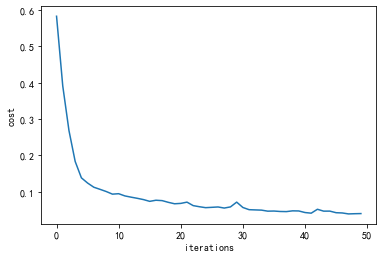

Train Accuracy: 98.45%
Test Accuracy: 80.70%


In [13]:
# 训练模型
max_len = 50
batch_size = 500
hidden_dim = 100
params_save_path = r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/emo_parms.pkl"
pred_y_test = train_model(X_train, y_train, X_test, y_test, word_to_vec, word_to_index, params_save_path, 
                    max_len=max_len, batch_size=batch_size, hidden_dim=hidden_dim, lr=0.002, epochs=50)

In [14]:
# 混淆矩阵
def confuse_matrix(y, pred_y):
    fp = np.sum((pred_y==1)&(y==0))
    fn = np.sum((pred_y==0)&(y==1))
    tp = np.sum((pred_y==1)&(y==1))
    tn = np.sum((pred_y==0)&(y==0))
    confuse_matrix = np.array([[tp, fp], [fn, tn]])
    precision = tp / (fp+tp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision*recall) / (precision+recall)
    print(confuse_matrix)
    print('Precision = %.2f,   Recall = %.2f    F1 = %.2f' % (precision, recall, F1))

In [15]:
# 参数评估
confuse_matrix(y_test, pred_y_test)

[[2527  455]
 [ 618 1960]]
Precision = 0.85,   Recall = 0.80    F1 = 0.82


In [18]:
# 载入模型
model = EmotionModel(word_to_vec, word_to_index, max_len, hidden_dim)
model.load_state_dict(torch.load(params_save_path))
model.eval()
# 待预测的评论
r1 = '说实话这是一款非常不错的游戏！画质细腻，最重要的是可以切换横屏竖屏！惊喜啊！现在想玩到高质量的竖屏暗黑游戏太难啦！18元超值！'
r2 = '先不说肝不肝，这个游戏的行走机制玩的真想让人砸手机，跑步和行走就是在走格子，见怪停顿然后你走一步怪走一步，受不了。'
r3 = '这游戏玩不懂啊，感觉引导很奇怪，然后里面的机制也很奇怪，玩得一脸懵逼，啥跟啥都不知道...'
r4 = '游戏是好游戏，代理太差了，毫无征兆说要开始测试，又随便找个理由跳票，既然没准备测试就不要放出消息啊，用这样的方法刷一波存在感有意思吗？'
r5 = '今天刚玩，感觉很有趣，制作很良心。很多细节。感觉应该挺耐玩。剧情写得很有意思。很多可以探索的。感觉还蛮值得一玩的。'
r6 = '这些游戏啊，进都不好进'
list1 = [r1, r2, r3, r4, r5, r6]
list2 = list1.copy()
for i in range(len(list2)):
    list2[i] = drop_stop_words(r"/Users/yangchaoran/Desktop/Now learnin'/2024-2025 Sp/文本挖掘/Final/源代码及数据/data/stop_words.txt",
                               split_text(drop_non_chinese(list2[i])))
test_review_indice = text_to_index(np.array(list2), word_to_index, max_len=max_len)
output = model(torch.from_numpy(test_review_indice).float())
pred = np.squeeze(np.round(output.data.numpy()).astype(int))
for i, j, k in zip(list1, output, pred):
    print('----\n评论：', i)
    print('预测评分：', ('大于8' if float(j) <= 0.5 else '小于8'))
    print('预测情感：', ('正向' if k == 0 else '负向'))

----
评论： 说实话这是一款非常不错的游戏！画质细腻，最重要的是可以切换横屏竖屏！惊喜啊！现在想玩到高质量的竖屏暗黑游戏太难啦！18元超值！
预测评分： 大于8
预测情感： 正向
----
评论： 先不说肝不肝，这个游戏的行走机制玩的真想让人砸手机，跑步和行走就是在走格子，见怪停顿然后你走一步怪走一步，受不了。
预测评分： 小于8
预测情感： 负向
----
评论： 这游戏玩不懂啊，感觉引导很奇怪，然后里面的机制也很奇怪，玩得一脸懵逼，啥跟啥都不知道...
预测评分： 小于8
预测情感： 负向
----
评论： 游戏是好游戏，代理太差了，毫无征兆说要开始测试，又随便找个理由跳票，既然没准备测试就不要放出消息啊，用这样的方法刷一波存在感有意思吗？
预测评分： 小于8
预测情感： 负向
----
评论： 今天刚玩，感觉很有趣，制作很良心。很多细节。感觉应该挺耐玩。剧情写得很有意思。很多可以探索的。感觉还蛮值得一玩的。
预测评分： 大于8
预测情感： 正向
----
评论： 这些游戏啊，进都不好进
预测评分： 小于8
预测情感： 负向
